## Analyze e2e latencies for the single_client_e2e experiment

In [15]:
import numpy as np
import glob

def get_append_metrics(path):
    file_pattern = path + "append_metrics*.csv"

    total_throughput = 0
    latency_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                gsn, latency, throughput = int(parts[0]), float(parts[1]), float(parts[2])
                latency_values.append(latency)
            
            total_throughput += throughput

    latency_array = np.array(latency_values)

    mean_latency = np.mean(latency_array)
    p50_latency = np.percentile(latency_array, 50)
    p99_latency = np.percentile(latency_array, 99)

    print("results for computation time " + path.split("_")[-1].split("/")[0] + " us")
    print("statistic/metric, latency (us)")
    print(f"mean, {mean_latency:.2f}")
    print(f"p50, {p50_latency:.2f}")
    print(f"p99, {p99_latency:.2f}")
    print(f"total throughput, {total_throughput:.2f}")

    return int(path.split("_")[-1].split("/")[0]), mean_latency, total_throughput 

def get_e2e_metrics(path):
    file_pattern = path + "e2e_metrics*.csv"

    delivery_latency_values = []
    compute_latency_values = []
    confirmation_latency_values = []
    e2e_latency_values = []
    queuing_delay_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                delivery, confirm, compute, e2e, queuing_delay = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5])
                delivery_latency_values.append(delivery)
                compute_latency_values.append(compute)
                confirmation_latency_values.append(confirm)
                e2e_latency_values.append(e2e)
                queuing_delay_values.append(queuing_delay)

    
    delivery_latency_array = np.array(delivery_latency_values)
    compute_latency_array = np.array(compute_latency_values)
    confirmation_latency_array = np.array(confirmation_latency_values)
    e2e_latency_array = np.array(e2e_latency_values)
    queuing_delay_array = np.array([x for x in queuing_delay_values if x > 0])

    print("statistic/metric, delivery latency (us), compute latency (us), confirm latency (us), e2e latency (us), queuing delay (us)")
    print(f"mean, {np.mean(delivery_latency_array):.2f}, {np.mean(compute_latency_array):.2f}, {np.mean(confirmation_latency_array):.2f}, {np.mean(e2e_latency_array):.2f}, {np.mean(queuing_delay_array):.2f}")
    print(f"std, {np.std(delivery_latency_array):.2f}, {np.std(compute_latency_array):.2f}, {np.std(confirmation_latency_array):.2f}, {np.std(e2e_latency_array):.2f}, {np.std(queuing_delay_array):.2f}")
    print(f"p50, {np.percentile(delivery_latency_array, 50):.2f}, {np.percentile(compute_latency_array, 50):.2f}, {np.percentile(confirmation_latency_array, 50):.2f}, {np.percentile(e2e_latency_array, 50):.2f}, {np.percentile(queuing_delay_array, 50):.2f}")
    print(f"p99, {np.percentile(delivery_latency_array, 99):.2f}, {np.percentile(compute_latency_array, 99):.2f}, {np.percentile(confirmation_latency_array, 99):.2f}, {np.percentile(e2e_latency_array, 99):.2f}, {np.percentile(queuing_delay_array, 99):.2f}")

    return int(path.split("_")[-1].split("/")[0]), np.mean(delivery_latency_array), np.mean(compute_latency_array), np.mean(confirmation_latency_array), np.mean(e2e_latency_array), np.mean(queuing_delay_array)

In [16]:
path = "../results/*"

for dir in glob.glob(path + "*/"):
    get_append_metrics(dir)
    get_e2e_metrics(dir)


results for computation time 2000 us
statistic/metric, latency (us)
mean, 3247.95
p50, 3158.00
p99, 5077.00
total throughput, 11312.15
statistic/metric, delivery latency (us), compute latency (us), confirm latency (us), e2e latency (us), queuing delay (us)
mean, 1369.82, 4394.28, 3346.69, 4442.43, 1012.82
std, 2293.29, 2376.86, 2422.69, 2487.67, 585.18
p50, 1068.00, 4316.00, 3228.00, 4350.00, 1011.00
p99, 2901.00, 6470.00, 5141.00, 6500.00, 1998.00


In [ ]:
import re
import pandas as pd

# Input data
data = """
PASTE DATA FROM OUTPUT ABOVE
"""

# Split data into lines
lines = data.splitlines()

# Parsing logic
results = []
current_time = None
append_latency = None

for i, line in enumerate(lines):
    line = line.strip()
    # Detect computation time
    if line.startswith("results for computation time"):
        match = re.search(r"computation time (\d+) us", line)
        if match:
            current_time = int(match.group(1))
    # Extract append latency (first "latency (us)" mean value)
    elif "statistic/metric, latency (us)" in line:
        append_line = lines[i + 1]  # Look at the next line
        append_match = re.match(r"mean,\s*([\d.]+)", append_line)
        if append_match:
            append_latency = float(append_match.group(1))
    # Extract other latencies (mean values)
    elif line.startswith("mean,") and current_time is not None:
        parts = line.split(",")
        if len(parts) == 6:  # Ensure correct format
            delivery_latency, compute_latency, confirm_latency, e2e_latency, queueing_delay = map(float, parts[1:])
            results.append({
                "computation_time": current_time,
                "append_latency": append_latency,
                "delivery_latency": delivery_latency,
                "compute_latency": compute_latency,
                "confirm_latency": confirm_latency,
                "e2e_latency": e2e_latency,
                "queueing_delay": queueing_delay,
            })

# Create a DataFrame
df = pd.DataFrame(results)

df.to_csv("output.csv", index=False)

# Print the CSV content
print(df.to_csv(index=False))

### Analyze order server log from the reconfiguration experiment

In [ ]:
import re
import matplotlib.pyplot as plt
from datetime import datetime

# File path
log_file = "../results/reconfig_1000/order-0.log"

# Regex patterns
tput_pattern = r"\[real-time tput\]: (\d+) ops/sec"
timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"

# Data storage
timestamps = []
tput_values = []
shard_join_request = []
shard_notified_to_be_added = []
shard_notified_to_be_removed = []
first_cut_committed = []
last_cut_committed = []
shard_leave_request = []

# Parse the log file
with open(log_file, "r") as f:
    for line in f:
        # Extract real-time throughput
        tput_match = re.search(tput_pattern, line)
        timestamp_match = re.search(timestamp_pattern, line)
        
        if tput_match and timestamp_match:
            tput_values.append(int(tput_match.group(1)))
            timestamps.append(datetime.strptime(timestamp_match.group(1), "%H:%M:%S.%f"))
        
        # Extract events for annotation
        if "Shard 1 to be added in next avl window" in line:
            shard_join_request.append(timestamp_match.group(1))

        if shard_notified_to_be_added == [] and "shardQuotas:<key:2" in line:
            shard_notified_to_be_added.append(timestamp_match.group(1))
        
        if first_cut_committed == [] and "cut:<key:2" in line:
            first_cut_committed.append(timestamp_match.group(1))
        
        if last_cut_committed == [] and "Replica 2 finalized" in line:
            last_cut_committed.append(timestamp_match.group(1))

        if "Shard 1 to be finalized in next avl window" in line:
            shard_leave_request.append(timestamp_match.group(1))

        if "Incrementing view ID because shardFinalized: true" in line:
            shard_notified_to_be_removed.append(timestamp_match.group(1))


# Convert timestamps to seconds since the start
start_time = timestamps[0]
time_in_seconds = [(ts - start_time).total_seconds() for ts in timestamps]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_in_seconds, tput_values, label="Throughput (ops/sec)", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Throughput (ops/sec)")
plt.title("Real-time Throughput vs Time")
plt.grid()

# Event times
shard_join_request = (datetime.strptime(shard_join_request[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_notified_to_be_added_time = (datetime.strptime(shard_notified_to_be_added[0], "%H:%M:%S.%f") - start_time).total_seconds()
first_cut_committed_time = (datetime.strptime(first_cut_committed[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_leave_request_time = (datetime.strptime(shard_leave_request[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_notified_to_be_removed_time = (datetime.strptime(shard_notified_to_be_removed[0], "%H:%M:%S.%f") - start_time).total_seconds()
last_cut_committed_time = (datetime.strptime(last_cut_committed[0], "%H:%M:%S.%f") - start_time).total_seconds()

# Add vertical lines for events
plt.axvline(shard_join_request, color="red", linestyle="--", alpha=0.7, label="shard requests to join")
plt.axvline(shard_notified_to_be_added_time, color="green", linestyle="--", alpha=0.7, label="shard notified about addition window")
plt.axvline(first_cut_committed_time, color="purple", linestyle="--", alpha=0.7, label="first cut committed from new shard")
plt.axvline(shard_leave_request_time, color="orange", linestyle="--", alpha=0.7, label="shard requests to leave")
plt.axvline(shard_notified_to_be_removed_time, color="brown", linestyle="--", alpha=0.7, label="shard notified about removal window")
plt.axvline(last_cut_committed_time, color="black", linestyle="--", alpha=0.7, label="last cut committed from leaving shard")

# Zoom in to the relevant range (adjust as needed)
# plt.xlim(22.8, 23.5)
# plt.xlim(10, 65)
# plt.xlim(51, 55)

# Add legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Events")

# Adjust layout to ensure the legend doesn't overlap with the plot
plt.tight_layout()

# Save the plot
plt.savefig("adding_reconfig_throughput_annotated.png", dpi=600)

plt.show()


## Analyze script for lagfix expt

In [ ]:
import re
import math

def find_nearest_multiple_of_3(number):
    return math.ceil(number / 3) * 3
    
def process_logs(logfile1, logfile2, logfile3):
    # Step 1: Extract the number from logfile1
    with open(logfile1, 'r') as file1:
        for line in file1:
            match = re.search(r"burst record with lsn (\d+)", line)
            if match:
                number = int(match.group(1))
                y = find_nearest_multiple_of_3(number)
                break
        else:
            raise ValueError("No 'burst record with lsn' found in logfile1")
    
    # Step 2: Locate and fetch lines from logfile2
    with open(logfile2, 'r') as file2:
        lines = file2.readlines()
    
    target_index = None
    for i, line in enumerate(lines):
        if f"cut:{y} cut:0" in line:
            target_index = i
            break
    
    if target_index is None:
        raise ValueError(f"No line containing 'cut:{y} cut:0' found in logfile2")
    
    # Fetch 2000 lines before and after
    start = max(0, target_index - 200)
    end = min(len(lines), target_index + 200)
    selected_lines = lines[start:end]
    
    # Step 3: Write to logfile3
    with open(logfile3, 'w') as file3:
        file3.writelines(selected_lines)

    return y



In [ ]:
logfile1 = "../results/lagfix_relaxed/data-0-0.log"
logfile2 = "../results/lagfix_relaxed/order-0.log"
logfile3 = "output.log"

y = process_logs(logfile1, logfile2, logfile3)

In [ ]:
import re

def extract_events(log_file, y):
    shard_0_cuts = []
    shard_1_cuts = []
    
    lagfix_detected = []
    lagfix_notified = []
    lagfix_resolved = []
    burst_start = []

    # Generic pattern for timestamps
    timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"

    with open(log_file, 'r') as file:
        for line in file:
            # Check for shard 0 cuts
            match_shard_0 = re.search(fr"{timestamp_pattern} cut:(\d+) cut:0", line)
            if match_shard_0:
                timestamp, cut = match_shard_0.groups()
                shard_0_cuts.append((timestamp, int(cut)))

            # Check for shard 1 cuts
            match_shard_1 = re.search(fr"{timestamp_pattern} localReplicaID:1 cut:0 cut:(\d+)", line)
            if match_shard_1:
                timestamp, cut = match_shard_1.groups()
                shard_1_cuts.append((timestamp, int(cut)))

            if burst_start == [] and "cut:" + str(y) + " cut:0" in line:
                burst_start.append(re.search(timestamp_pattern, line).group(1))

            if burst_start != [] and lagfix_detected == [] and "significant lag in cuts:" in line:
                lagfix_detected.append(re.search(timestamp_pattern, line).group(1))

            if burst_start != [] and lagfix_notified == [] and "adjustmentSignal:" in line:
                lagfix_notified.append(re.search(timestamp_pattern, line).group(1))
            
            if burst_start != [] and lagfix_resolved == [] and "fixedLag:true" in line:
                lagfix_resolved.append(re.search(timestamp_pattern, line).group(1))


    return shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start


# Example usage
log_file = "output.log"
shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start = extract_events(log_file, y)




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib.ticker import MultipleLocator, MaxNLocator, FuncFormatter


def parse_timestamp(timestamp):
    return datetime.strptime(timestamp, "%H:%M:%S.%f")


def plot_events_zoomed(
    shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start, zoom_event="Lag Detected", zoom_window_ms=100
):
    # Convert timestamps to datetime objects
    shard_0_times = [parse_timestamp(t) for t, _ in shard_0_cuts]
    shard_0_values = [1 for _ in shard_0_cuts]  # Level 1 for Shard 0

    shard_1_times = [parse_timestamp(t) for t, _ in shard_1_cuts]
    shard_1_values = [2 for _ in shard_1_cuts]  # Level 2 for Shard 1

    # Parse event timestamps
    event_times = {
        "Lag Detected": [parse_timestamp(lagfix_detected[0])] if lagfix_detected else [],
        "Lag Notified": [parse_timestamp(lagfix_notified[0])] if lagfix_notified else [],
        "Lag Resolved": [parse_timestamp(lagfix_resolved[0])] if lagfix_resolved else [],
        "Burst Start": [parse_timestamp(burst_start[0])] if burst_start else [],
    }

    # Event colors for differentiation
    event_colors = {
        "Lag Detected": "red",
        "Lag Notified": "purple",
        "Lag Resolved": "green",
        "Burst Start": "brown",
    }

    # Find the minimum timestamp across all events and cuts
    all_times = shard_0_times + shard_1_times
    for times in event_times.values():
        all_times.extend(times)

    min_timestamp = min(all_times)

    # Convert all timestamps to relative time (milliseconds since min_timestamp)
    def to_relative_ms(time):
        return (time - min_timestamp).total_seconds() * 1000

    shard_0_times_rel = [to_relative_ms(t) for t in shard_0_times]
    shard_1_times_rel = [to_relative_ms(t) for t in shard_1_times]

    # Parse event times as relative times
    event_times_rel = {
        event_name: [to_relative_ms(t) for t in times]
        for event_name, times in event_times.items()
    }

    # Determine the time range for zooming
    if zoom_event not in event_times_rel or not event_times_rel[zoom_event]:
        print(f"No event found for {zoom_event}.")
        return

    zoom_time = event_times_rel[zoom_event][0]
    zoom_start = zoom_time - zoom_window_ms
    zoom_end = zoom_time + zoom_window_ms

    # Filter data for the zoomed time range
    shard_0_times_zoomed = [t for t in shard_0_times_rel if zoom_start <= t <= zoom_end]
    shard_1_times_zoomed = [t for t in shard_1_times_rel if zoom_start <= t <= zoom_end]

    # Start plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot cut points for Shard 0 with stacking
    ax.scatter(shard_0_times_zoomed, [1 + 0.05 * i for i in range(len(shard_0_times_zoomed))], label="Shard 0 Cuts", color="blue", marker="o", s=40, alpha=0.6)

    # Plot cut points for Shard 1 with stacking
    ax.scatter(shard_1_times_zoomed, [2 + 0.05 * i for i in range(len(shard_1_times_zoomed))], label="Shard 1 Cuts", color="orange", marker="o", s=40, alpha=0.6)

    # Plot vertical lines for events within the zoom window
    for event_name, times in event_times_rel.items():
        for time in times:
            if zoom_start <= time <= zoom_end:
                ax.axvline(time, linestyle="--", label=event_name, color=event_colors[event_name], alpha=0.7)

    # Adjust x-axis for 1 ms ticks
    ax.xaxis.set_major_locator(MultipleLocator(1))  # 1 ms ticks
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))  # Show milliseconds as integers

    # Adjust number of ticks on the x-axis
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, prune='both'))  # Use nbins to control tick density

    # Set the x-limits to zoom in on the window
    ax.set_xlim(zoom_start, zoom_end)

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

    # Adjust y-axis
    ax.set_yticks([1, 2])
    ax.set_yticklabels(["Shard 0", "Shard 1"])

    # Add labels and legend
    ax.set_xlabel("Time (ms relative to min timestamp)")
    ax.set_ylabel("Shards")
    ax.set_title(f"Zoomed View: {zoom_event} (±{zoom_window_ms} ms)")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Legend", shadow=True)

    # Show the plot
    plt.tight_layout()
    plt.savefig("output.png", dpi=600)


# Example usage (assuming shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start are defined)
plot_events_zoomed(shard_0_cuts, shard_1_cuts, lagfix_detected, lagfix_notified, lagfix_resolved, burst_start, zoom_event="Burst Start", zoom_window_ms=20)


## Analyze script for the aggresive lagfix vs no lagfix latency plots

In [ ]:
import numpy as np
import glob

def get_append_metrics_for_lagfix(path):
    file_pattern = path + "append_latency_timestamp_0.csv"
    latency_values = {}
    gsns = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]  # Skip the header
            for line in lines:
                parts = line.strip().split(',')
                gsn, timestamp, latency = int(parts[0]), parts[1], int(parts[2])
                latency_values[gsn] = [latency, timestamp]

    client_file = path + "client_node13_0.log"
    with open(client_file, 'r') as f:
        log_data = f.read()
        for line in log_data.splitlines():
            if "gsn: " in line:
                try:
                    gsn = int(line.split()[-1])  
                    gsns.append(gsn)
                except ValueError:
                    print(f"Skipping invalid GSN: {line.split()[-1]}")

    gsns.sort()
    return latency_values, gsns

# CONFIGURE PATH HERE (without or aggressive)
path = "../results/lagfix_without/"
latency_values, gsns = get_append_metrics_for_lagfix(path)

latency_array = np.array([latency_values[gsn][0] for gsn in latency_values])
mean_latency = np.mean(latency_array)
p99_latency = np.percentile(latency_array, 99)

print(f"Mean latency: {mean_latency:.2f} us")
print(f"P99 latency: {p99_latency:.2f} us")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
latency_times = []
latencies = []
for gsn, (latency, timestamp) in latency_values.items():
    latency_times.append(datetime.strptime(timestamp, "%H:%M:%S.%f"))
    latencies.append(latency)

df = pd.DataFrame({
    'time': latency_times,
    'latency': latencies
})

df = df.sort_values(by='time')

# CONFIGURE WINDOW SIZE HERE
window_size = 10  # Set the window size for the moving average
df['moving_avg'] = df['latency'].rolling(window=window_size, min_periods=1).mean()

min_time = df['time'].min()
df['relative_time_ms'] = (df['time'] - min_time).dt.total_seconds() * 1000

# CONFIGURE ZOOM IN PERIOD HERE
start_time = datetime.strptime(latency_values[gsns[0]][1], "%H:%M:%S.%f") - timedelta(milliseconds=100)  
end_time = datetime.strptime(latency_values[gsns[-1]][1], "%H:%M:%S.%f") + timedelta(milliseconds=100)  

df_zoomed = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

plt.figure(figsize=(10, 6))
plt.plot(df_zoomed['relative_time_ms'], df_zoomed['moving_avg'], label=f'Moving Average (window={window_size})', color='blue', linewidth=2)


start_time_relative = (datetime.strptime(latency_values[gsns[0]][1], "%H:%M:%S.%f") - min_time).total_seconds() * 1000
end_time_relative = (datetime.strptime(latency_values[gsns[-1]][1], "%H:%M:%S.%f") - min_time).total_seconds() * 1000
plt.axvline(x=start_time_relative, color='green', linestyle=':', label=f'burst start time')
plt.axvline(x=end_time_relative, color='red', linestyle=':', label=f'burst end time')


plt.xlabel('Time (ms)')
plt.ylabel('Latency (us)')
plt.title('Latency Over Time with Moving Average')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output.png", dpi=600)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latency_vs_gsn(latency_values, gsns):
    sequence_numbers = list(latency_values.keys())
    latencies = [latency_values[gsn][0] for gsn in sequence_numbers]

    burst_start_gsn = gsns[0]
    burst_end_gsn = gsns[-1]
    
    start_index = sequence_numbers.index(burst_start_gsn)
    end_index = sequence_numbers.index(burst_end_gsn)
    
    # CONFIGURE WINDOW SIZE HERE
    window_start = max(start_index - 50, 0)
    window_end = min(end_index + 50, len(sequence_numbers) - 1)

    plt.figure(figsize=(12, 6))
    plt.plot(sequence_numbers[window_start:window_end+1], latencies[window_start:window_end+1], linestyle='-', label="Latency")

    plt.axvline(x=sequence_numbers[start_index], color='green', linestyle='--', label="Burst Start (GSN)")
    plt.axvline(x=sequence_numbers[end_index], color='purple', linestyle='--', label="Burst End (GSN)")

    plt.xlabel("GSN (Sequence Number)")
    plt.ylabel("Latency (us)")
    plt.title("Impact of bursts on latency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("latency_vs_gsn.png", dpi=600)

plot_latency_vs_gsn(latency_values, gsns)


# Failure Detection Experiment

In [36]:
from datetime import datetime, timedelta
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt

path='../results/1ms/append_bench_40/<hpnode*>_1m_4096_*.csv'

all_metric : list[tuple[int, int, datetime]] = []
for file in glob.glob(path):
    print(f'processing {file}')
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                all_metric.append((int(row.get('gsn')), int(row.get('latency(ns)')), datetime.strptime(row.get('runEndTime'), '%H:%M:%S.%f')))
            except Exception as e:
                print(f'Invalid value in row: {row}, {e}')
print('sorting..')
all_metric.sort(key=lambda x: x[0])
all_time = [l[2] for l in all_metric]
all_lat = [l[1] for l in all_metric]


sorting..


In [37]:
from datetime import datetime, timedelta
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt

path='../results/e2e_2000/e2e_metrics_*.csv'
all_e2e_metric : list[tuple[int, int, datetime]] = []
for file in glob.glob(path):
    print(f'processing {file}')
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                all_e2e_metric.append((int(row.get('gsn')), max(int(row.get('e2e latency (us)')), int(row.get('recompute latency (us)'))), datetime.strptime(row.get('start time'), '%H:%M:%S.%f')))
            except Exception as e:
                print(f'Invalid value in row: {row}, {e}')

path='../results/e2e_2000/append_metrics_*.csv'
all_append_metric : list[tuple[int, int]] = []
for file in glob.glob(path):
    print(f'processing {file}')
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                all_append_metric.append((int(row.get('gsn')), int(row.get('latency (us)'))))
            except Exception as e:
                print(f'Invalid value in row: {row}, {e}')

all_e2e_metric.sort(key=lambda x: x[0])
all_append_metric.sort(key=lambda x: x[0])
all_time = [l[2] for l in all_e2e_metric]
all_e2e_lat = [l[1] for l in all_e2e_metric]
all_append_lat = [l[1] for l in all_append_metric]

processing ../results/e2e_2000/e2e_metrics_0.csv
processing ../results/e2e_2000/append_metrics_0.csv


In [41]:

df = pd.DataFrame({
    'e2e_latency': all_e2e_lat,
    'app_latency': all_append_lat,
    'time': all_time,
})
df = df.sort_values(by='time')

zoom = (28, 29)

start_time = all_time[0] + timedelta(seconds=zoom[0])
end_time = all_time[0] + timedelta(seconds=zoom[1])

df['e2e_mov_avg'] = df['e2e_latency'].rolling(window=10, min_periods=1).mean()/1e3
df['app_mov_avg'] = df['app_latency'].rolling(window=10, min_periods=1).mean()/1e3
min_time = df['time'].min()
df['relative_time_s'] = (df['time'] - min_time).dt.total_seconds()

df_zoomed = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

failure_ev : datetime = None
viewchange_ev : datetime = None
with open('../results/e2e_2000/client_node11_0.log', 'r') as f:
    for line in f.readlines():
        if 'rpc error:' in line and failure_ev is None:
            failure_ev = datetime.strptime(line.split(' ')[2], '%H:%M:%S.%f')
            print(failure_ev)
        elif 'mis-spec' in line and viewchange_ev is None:
            viewchange_ev = datetime.strptime(line.split(' ')[2], '%H:%M:%S.%f')
            print(viewchange_ev)


1900-01-01 10:58:57.393714
1900-01-01 10:58:57.446802


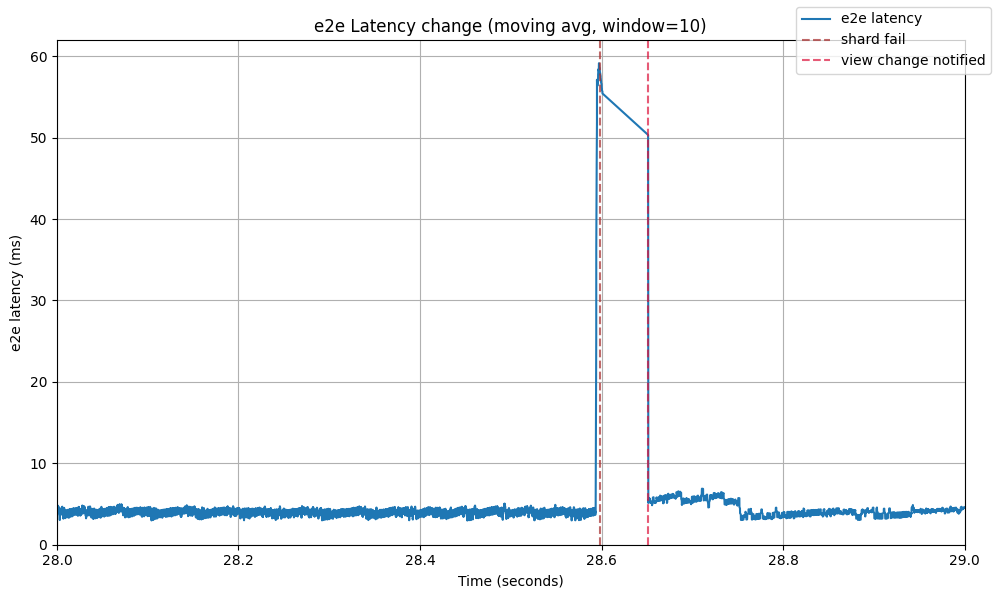

In [44]:


plot, ax = plt.subplots(figsize=(10,6))
ax.plot(df_zoomed['relative_time_s'], df_zoomed['e2e_mov_avg'], label='e2e latency')
# ax.plot(df_zoomed['relative_time_s'], df_zoomed['app_mov_avg'], color='grey', label='append latency')
ax.axvline((failure_ev - min_time).total_seconds(), color='brown', alpha=0.7, linestyle='--', label="shard fail")
ax.axvline((viewchange_ev - min_time).total_seconds(), color='crimson', alpha=0.7, linestyle='--', label="view change notified")
ax.set_xlim(left=zoom[0], right=zoom[1])
ax.set_ylim(bottom=0)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('e2e latency (ms)')
ax.set_title('e2e Latency change (moving avg, window=10)')
ax.grid()

plot.legend()
plot.tight_layout()
plt.show()


10:58:57.444939

last cut report 1900-01-01 10:58:57.390789
significant lag detected 1900-01-01 10:58:57.394503
shard failure detected 1900-01-01 10:58:57.444939
notify data servers 1900-01-01 10:58:57.445677


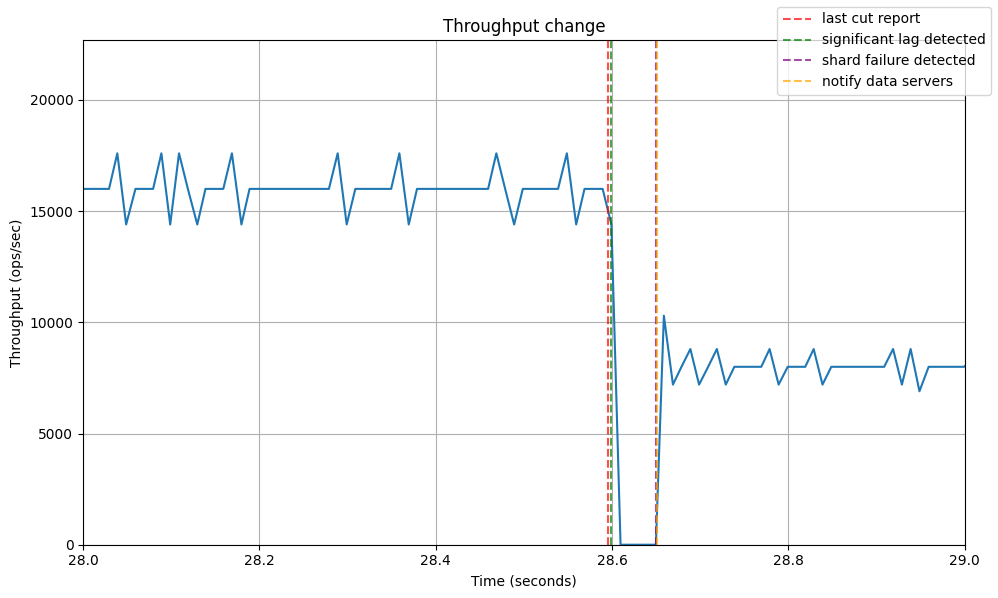

In [43]:


tput = []
time : 'list[datetime]' = []
event : 'dict[str, tuple[datetime, str]]' = {}
with open('../results/e2e_2000/order-0.log', 'r') as f:
    for line in f.readlines():
        if '[real-time tput]' in line:
            tput.append(int(line.split(' ')[-2]))
            time.append(datetime.strptime(line.split(' ')[-5], '%H:%M:%S.%f'))
        if '[last cut]'  in line:
            event['last cut report'] = (datetime.strptime(line.split(' ')[-1].rstrip(), '%H:%M:%S.%f'), 'red')
        elif '[lag detected]' in line:
            event['significant lag detected'] = (datetime.strptime(line.split(' ')[-1].rstrip(), '%H:%M:%S.%f'), 'green')
        elif '[fail detected]' in line:
            print(line.split(' ')[-1])
            event['shard failure detected'] = (datetime.strptime(line.split(' ')[-1].rstrip(), '%H:%M:%S.%f'), 'purple')
        elif '[cut commit]' in line:
            event['notify data servers'] = (datetime.strptime(line.split(' ')[-1].rstrip(), '%H:%M:%S.%f'), 'orange')

start_time = min_time
time_in_s = [(t - start_time).total_seconds() for t in time]

plot, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_in_s, tput)
ax.set_xlim(left=zoom[0], right=zoom[1])
ax.set_ylim(bottom=0)
ax.grid(True)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Throughput (ops/sec)")
ax.set_title("Throughput change")


for e, t in sorted(event.items(), key=lambda it: it[1][0]):  # sort by time
    print(e, t[0])
    ax.axvline((t[0]-start_time).total_seconds(), color=t[1], alpha=0.7, linestyle='--', label=e)


plot.legend()
plot.tight_layout()
plot.show()